In [44]:
import os, sys
from pathlib import Path
import torch
import tifffile as tiff

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 50
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [45]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
pca = test['pca']

img_names = test['img_names']

In [46]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [47]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [48]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [49]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [50]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

In [51]:
print(img_names[247], img_names[248])

00247_-0.253_S_-1.014_D_2.431_B.tiff 00248_0.455_S_0.342_D.tiff


In [52]:
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB
from monai.transforms import Compose, ToTensor
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])

image_shape = (crop_size, crop_size)

In [53]:
def hist_match(img):
    source_img_2d = img.reshape(image_shape).astype(np.float32)
    reference_img_2d = img.reshape(image_shape).astype(np.float32)
    
    source_img = sitk.GetImageFromArray(source_img_2d.astype(np.float32))
    reference_img = sitk.GetImageFromArray(reference_img_2d.astype(np.float32))
    
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(500)
    matcher.SetNumberOfMatchPoints(50)
    matcher.SetThresholdAtMeanIntensity(False)
    matched_img = matcher.Execute(source_img, reference_img)
    
    # Convert the matched image back to a numpy array and reshape to original shape
    matched_img_array = sitk.GetArrayFromImage(matched_img).reshape(-1)
    matched_images.append(matched_img_array)

In [54]:
import SimpleITK as sitk
import numpy as np
import torch

save_name = f'data/{exp_name}/cntr/'
cf_vals = {1:0}

residuals = test_imgs - pca.inverse_transform(encoded_data)

cf = np.zeros((248, ncomps))
for ev in range(0, ncomps - nbasecomps, nevecs - nbasecomps):
    ed = encoded_data[:248, ev:ev + nevecs]
    X_obs = np.hstack([disease[:248, np.newaxis], bias[:248, np.newaxis], ed])
    try:
        macaw = torch.load(model_base_path / f'{ev}.pt')
        cc = macaw.counterfactual(X_obs, cf_vals)
    except Exception as e:
        print(e, "Using original")
        cc[:, ncauses:] = X_obs[:, ncauses:].copy()

    cf[:, ev:ev + nevecs] = cc[:, ncauses:]

re_cf = recons(cc[:, 0], cc[:, 1], cf)
re_cf_resd = re_cf[2] + residuals[:248]

# Perform histogram matching
matched_images = []
for i in range(248):
    hist_match(re_cf_resd[i])

# Convert the matched images back to a numpy array
re_cf_resd = np.array(matched_images)

diff = test_imgs[:248] - re_cf_resd

In [55]:
nob_gt=[]

transforms_t = Compose([ToTensor(),CenterCrop(crop_size)])

for i in range(248):
    img = tiff.imread('no_bias/test/'+img_names[i])
    img = img / np.max(img)
    nob_gt.append(transforms_t(img).numpy())
    
# nob_gt = np.concatenate(nob_gt, axis=0)
# nob_gt = nob_gt.reshape(nob_gt.shape[0], -1)
nob_gt=np.array(nob_gt)
nob_gt_t = torch.tensor(nob_gt)
test_imgs_t = torch.tensor(test_imgs[:248])

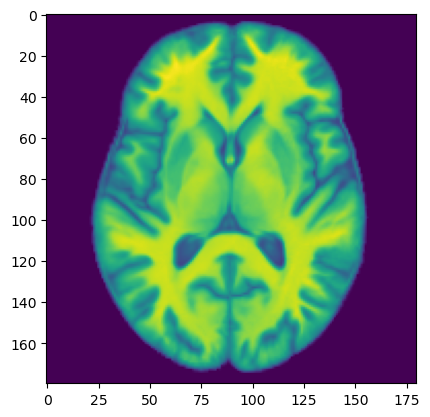

In [56]:
plt.imshow(nob_gt[0].reshape(crop_size,crop_size))

In [57]:
np.max(nob_gt[0])

1.0

In [58]:
mse_loss = torch.nn.MSELoss()
mse_list = []

for i in range(248):
    img1 = torch.tensor(re_cf_resd[i]).float()  # Ensure the image is a float tensor
    img2 = test_imgs_t[i].float()  # Ensure the image is a float tensor
    mse = mse_loss(img1, img2).item()
    mse_list.append(mse)

# Convert mse_list to a numpy array for easier manipulation if needed
mse_array_og = np.array(mse_list)

In [59]:
# original with bias vs cf with no bias
og = np.mean(mse_array_og)

In [60]:
mse_loss = torch.nn.MSELoss()
mse_list = []

for i in range(248):
    img1 = torch.tensor(re_cf_resd[i].reshape(crop_size,crop_size)).float()  # Ensure the image is a float tensor
    img2 = nob_gt_t[i].float()  # Ensure the image is a float tensor
    mse = mse_loss(img1, img2).item()
    mse_list.append(mse)

# Convert mse_list to a numpy array for easier manipulation if needed
mse_array_gt = np.array(mse_list)

In [61]:
# ground truth no bias vs cf with no bias
gt = np.mean(mse_array_gt)

In [62]:
print(og,gt)

0.0009641124706831761 0.00039295296392816864


In [63]:
print(f"Bias>NoBias CF has an {abs(og - gt) / ((og + gt) / 2) * 100:.2f}% higher MSE when compared to the original biased image then it does to the unbiased ground truth")

Bias>NoBias CF has an 84.18% higher MSE when compared to the original biased image then it does to the unbiased ground truth


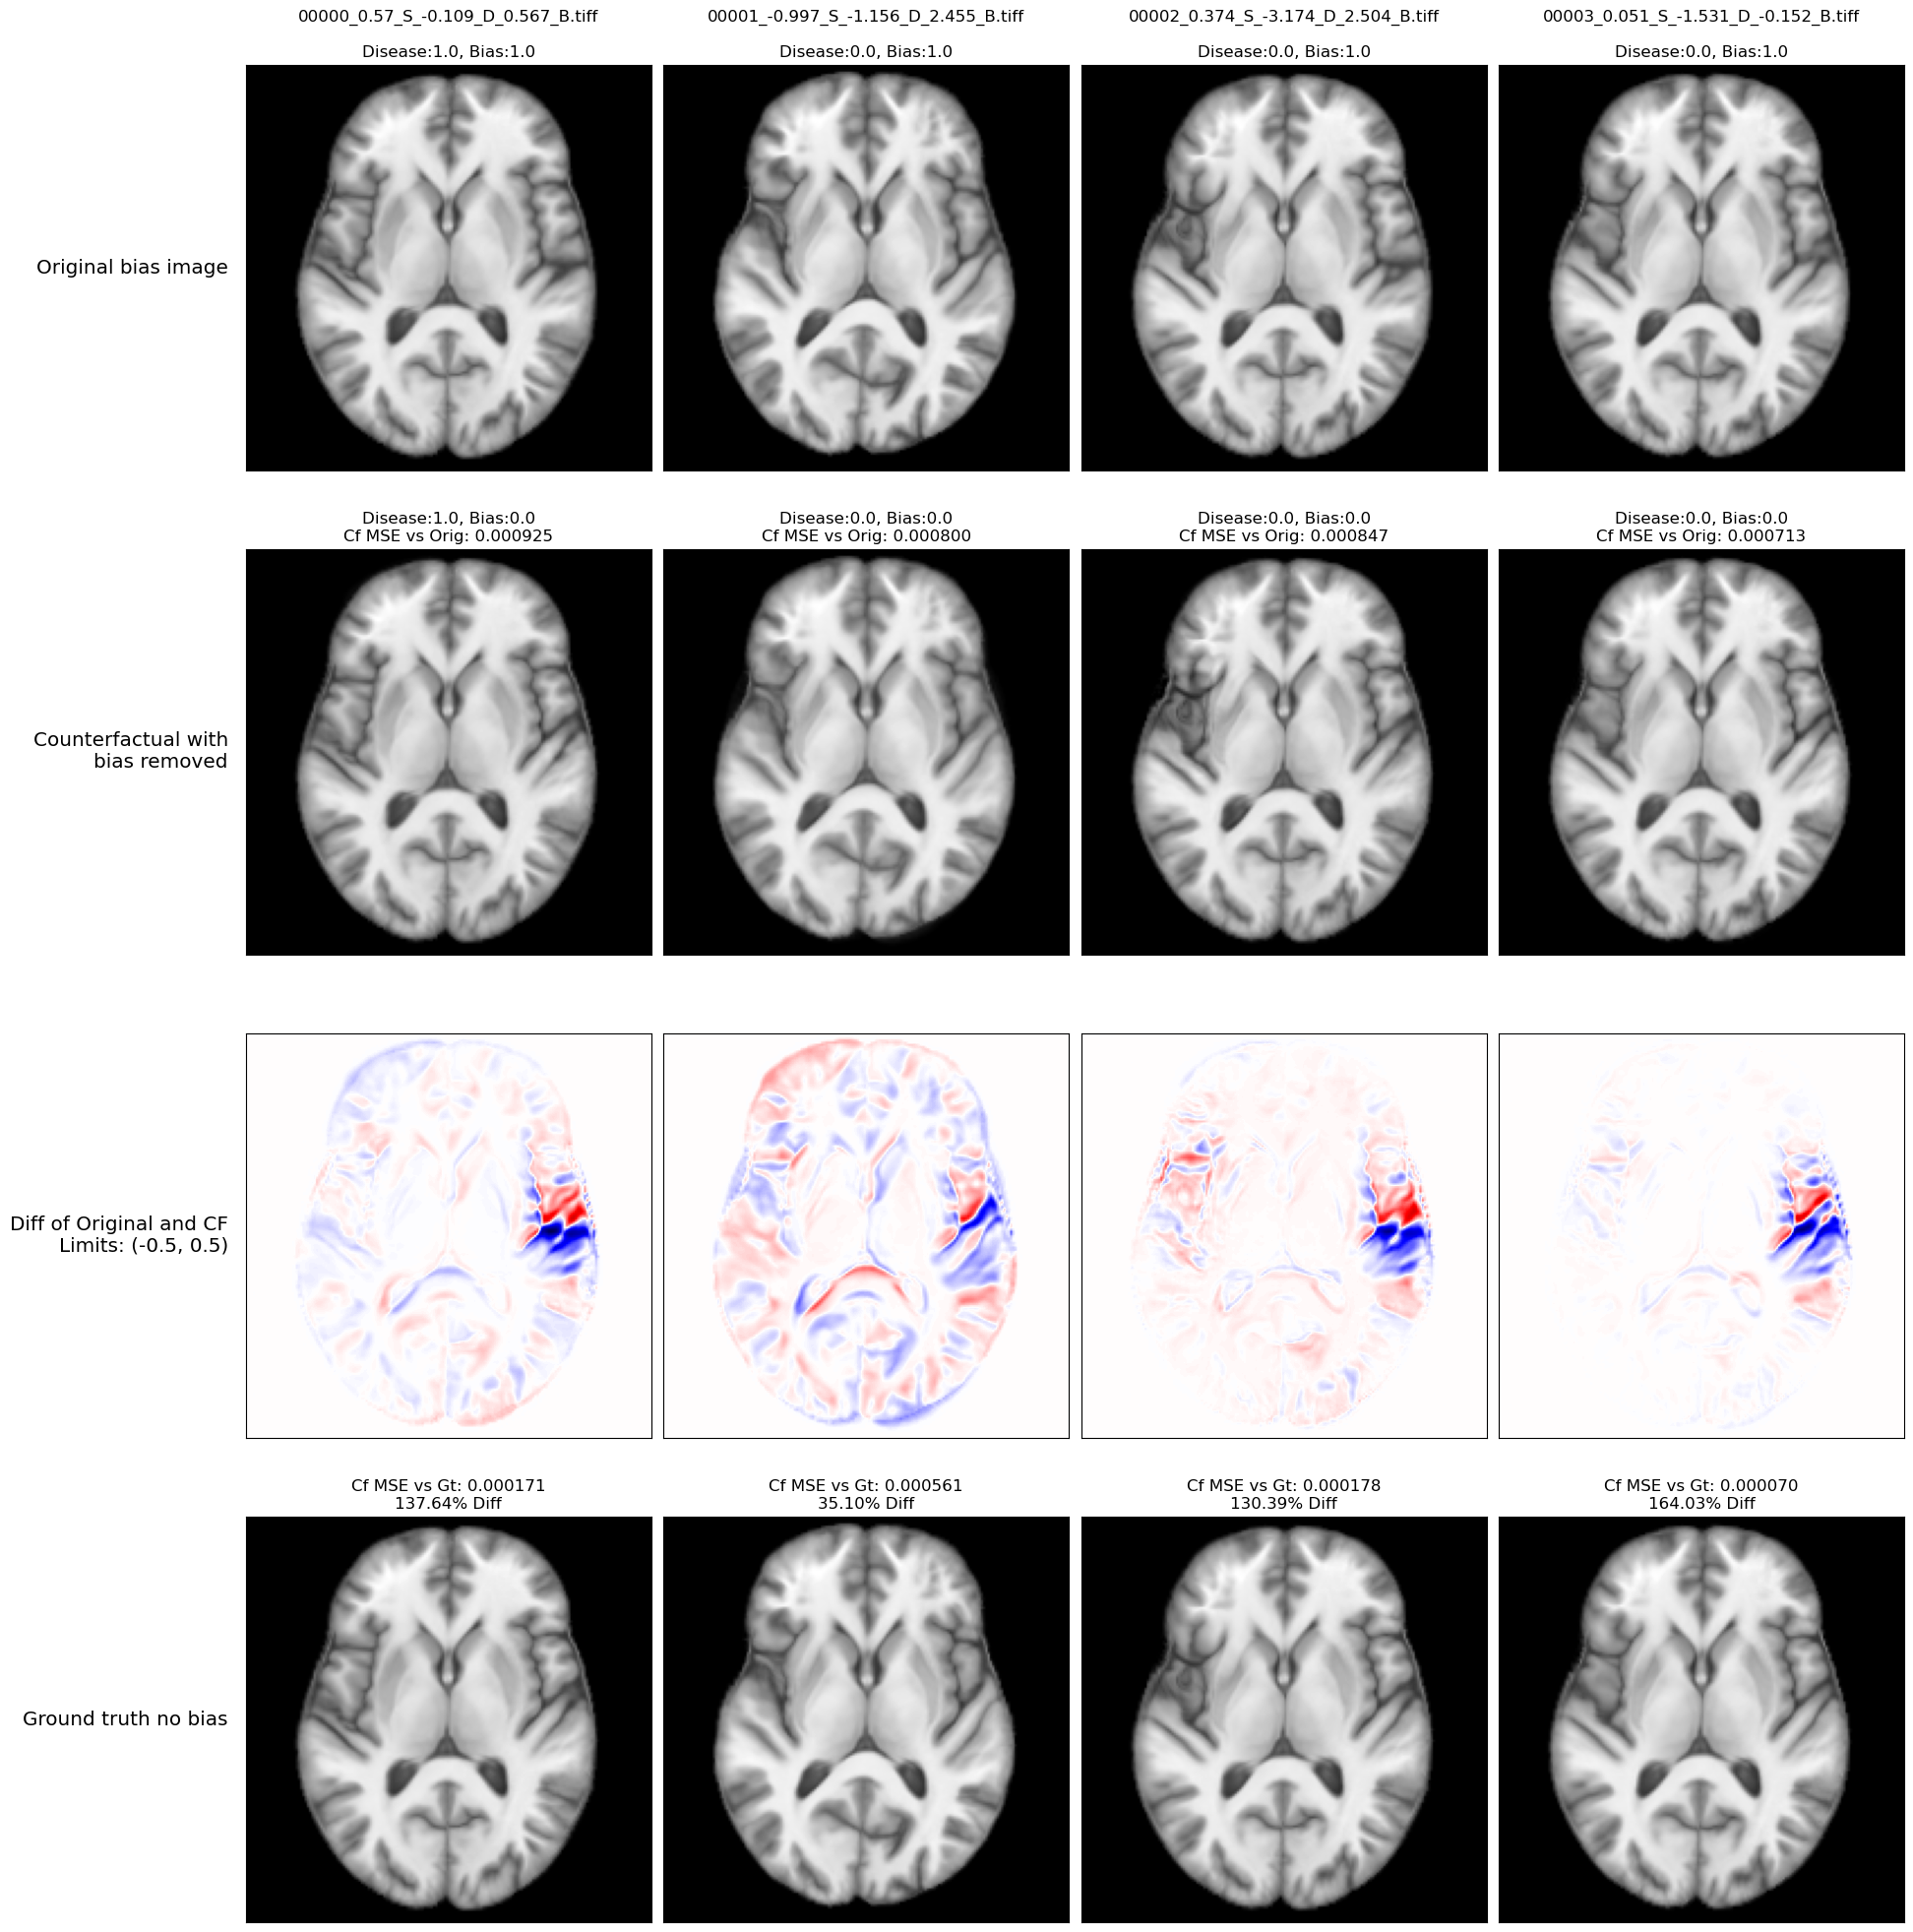

In [64]:
fig,axs = plt.subplots(4,4, figsize=(20,20))

lim=0.5
lims=(-lim,lim)

for i in range(4):
    axs[0,i].imshow(test_imgs[i].reshape(crop_size,crop_size),cmap='gray')
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'{img_names[i]}\n\nDisease:{X_obs[i,0]}, Bias:{X_obs[i,1]}')

    axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
    axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{cc[i,0]}, Bias:{cc[i,1]}\nCf MSE vs Orig: {mse_array_og[i]:6f}')

    axs[2,i].imshow(diff[i].reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    t = pca.transform(nob_gt[i].reshape(1,-1))
    X_recon = pca.inverse_transform(t)

    axs[3,i].imshow(    X_recon.reshape(crop_size,crop_size),cmap='gray')
    axs[3,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f"Cf MSE vs Gt: {mse_array_gt[i]:6f}\n{abs(mse_array_gt[i] - mse_array_og[i]) / ((mse_array_gt[i] + mse_array_og[i]) / 2) * 100:.2f}% Diff")
    # 
    # # diff between cf no_bias and ground truth no_bias, ideally would have no difference
    # axs[4,i].imshow((re_cf_resd[i].reshape(crop_size,crop_size)) -     X_recon.reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    # axs[4,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    # 
    # # shows the bias Emma added
    # axs[5,i].imshow(test_imgs[i].reshape(crop_size,crop_size) -     X_recon.reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    # axs[5,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
# Add labels to the left side of each row
for ax, label in zip(axs[:, 0], ['Original bias image', 'Counterfactual with\nbias removed', f'Diff of Original and CF\nLimits: {lims}', 'Ground truth no bias']):
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.15)  # Adjust to make room for the labels
    
if not os.path.exists(save_name):
    os.makedirs(save_name)

plt.savefig(save_name+f"cf1.pdf")
plt.show()

In [67]:
import csv

with open("mse.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Filename', 'MSE of CF and Biased Original', 'MSE of CF and Unbiased Ground Truth'])
    # Write the data
    for filename, mse1, mse2 in zip(img_names[:248], mse_array_og, mse_array_gt):
        writer.writerow([filename, mse1, mse2])